## Inicjalizacja

In [1]:
# !pip install -r https://hub.optuna.org/samplers/confopt_sampler/requirements.txt -q # installing optuna on steroids

In [2]:
from sklearn.datasets import make_moons
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, random_split, TensorDataset
import os
from tqdm.notebook import tqdm
import optuna
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import warnings
import optunahub
warnings.filterwarnings('ignore')
! nvidia-smi
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(42)

/bin/bash: line 1: nvidia-smi: command not found


## MLP

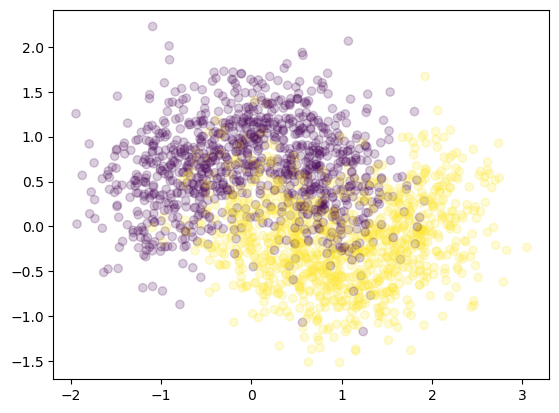

In [3]:
whole_moons = make_moons(n_samples=2000, noise=0.4, random_state=42)
plt.scatter(whole_moons[0][:, 0], whole_moons[0][:, 1], c=whole_moons[1], alpha=0.2)

In [4]:
print(whole_moons[0].shape[0])
print(whole_moons[0].shape[1])
print(whole_moons[1].shape)
print(whole_moons[0][0])
print(whole_moons[0][1])
print(whole_moons[1][0])


2000
2
(2000,)
[1.38810266 0.54100006]
[0.25749836 1.03434128]
1


In [5]:
class MLPClassifier(nn.Module):
    def __init__(self, depth=7, input_dim=2, hidden_dim=64, out_dim=1):
        super().__init__()
        
        if depth < 2:
            raise ValueError("DEPTH < 2")
        
        last_hidden_dim = max(hidden_dim // 2, out_dim * 2) 
        hidden_sizes = np.linspace(
            start=hidden_dim, 
            stop=last_hidden_dim, 
            num=depth - 1, 
            dtype=int
        ).tolist()
        layer_dims = [input_dim] + hidden_sizes

        layers = []
        layers.append(nn.Flatten())
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            layers.append(nn.ReLU())
            
        self.seq = nn.Sequential(*layers)
        
        self.head = nn.Linear(layer_dims[-1], out_dim)
    
    def forward(self, x, embeddingFlag=False):
        features = self.seq(x)
        if embeddingFlag:
            return features
        return self.head(features)
    
    def extract(self, Loader):
        embeddings = []
        labels = []
        
        self.eval() 
        with torch.no_grad():
            for X, y in Loader:
                X = X.to(DEVICE)
                emb = self.forward(X, embeddingFlag=True)
                embeddings.append(emb.cpu())
                labels.append(y.cpu())
        embeddings = torch.cat(embeddings, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()
        return embeddings, labels

In [6]:
model = MLPClassifier()
model.to(DEVICE)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [7]:
def train(loader, model, loss_fn, optimizer):
    size = len(loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn, text='Val'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred_logits = model(X)
            test_loss += loss_fn(pred_logits, y).item()
            predicted_labels = (pred_logits > 0).float()
            correct += (predicted_labels == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    
    print(f"{text} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
def accuracy_score_MLP(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred_logits = model(X)
            predicted_labels = (pred_logits > 0).float()
            correct += (predicted_labels == y).type(torch.float).sum().item()
            
    correct /= size
    return correct

In [10]:
def prepare_data(X, y, multiclass=False, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42)
    val_split = test_ratio / (test_ratio + val_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val   = torch.tensor(X_val, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)

    if multiclass:
        y_train = torch.tensor(y_train, dtype=torch.long)
        y_val   = torch.tensor(y_val, dtype=torch.long)
        y_test  = torch.tensor(y_test, dtype=torch.long)
    else:
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        y_val   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
        y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset   = TensorDataset(X_val, y_val)
    test_dataset  = TensorDataset(X_test, y_test)
    return train_dataset, val_dataset, test_dataset

In [11]:
ratio_train = 0.8; ratio_val = 0.1; ratio_test = 0.1
train_dataset, val_dataset, test_dataset = prepare_data\
    (whole_moons[0], whole_moons[1], multiclass=False, \
     train_ratio=ratio_train, val_ratio=ratio_val, test_ratio=ratio_test)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

1600
200
200


In [12]:
def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader
batch_size = 128
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

In [13]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss, optimizer)
    test(val_loader, model, loss) 


print("Final Test Score:")
accuracy_MLP = accuracy_score_MLP(test_loader, model)
test(test_loader, model, loss, text='Test')

Epoch 1
-------------------------------
loss: 0.694605  [  128/ 1600]
Val Error: 
 Accuracy: 65.0%, Avg loss: 0.682287 

Epoch 2
-------------------------------
loss: 0.677582  [  128/ 1600]
Val Error: 
 Accuracy: 80.0%, Avg loss: 0.615793 

Epoch 3
-------------------------------
loss: 0.621781  [  128/ 1600]
Val Error: 
 Accuracy: 81.5%, Avg loss: 0.457845 

Epoch 4
-------------------------------
loss: 0.408944  [  128/ 1600]
Val Error: 
 Accuracy: 82.0%, Avg loss: 0.390037 

Epoch 5
-------------------------------
loss: 0.430678  [  128/ 1600]
Val Error: 
 Accuracy: 83.5%, Avg loss: 0.380626 

Epoch 6
-------------------------------
loss: 0.432246  [  128/ 1600]
Val Error: 
 Accuracy: 84.5%, Avg loss: 0.369166 

Epoch 7
-------------------------------
loss: 0.320843  [  128/ 1600]
Val Error: 
 Accuracy: 84.0%, Avg loss: 0.358474 

Epoch 8
-------------------------------
loss: 0.360673  [  128/ 1600]
Val Error: 
 Accuracy: 84.5%, Avg loss: 0.348389 

Epoch 9
------------------------

In [14]:
model.eval()

MLPClassifier(
  (seq): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=57, bias=True)
    (4): ReLU()
    (5): Linear(in_features=57, out_features=51, bias=True)
    (6): ReLU()
    (7): Linear(in_features=51, out_features=44, bias=True)
    (8): ReLU()
    (9): Linear(in_features=44, out_features=38, bias=True)
    (10): ReLU()
    (11): Linear(in_features=38, out_features=32, bias=True)
    (12): ReLU()
  )
  (head): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
X_train, y_train = model.extract(train_loader)
X_val, y_val     = model.extract(val_loader)
X_test, y_test   = model.extract(test_loader)
print(type(X_train))
print(X_train.shape)
print(y_train)
print(y_train.shape)


<class 'numpy.ndarray'>
(1600, 32)
[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(1600, 1)


## RF

#### Standalone RandomForrest

In [16]:
X_sa, y_sa = whole_moons
X_train_sa, X_temp_sa, y_train_sa, y_temp_sa = train_test_split(X_sa, y_sa, test_size=0.2, random_state=42)
X_val_sa, X_test_sa, y_val_sa, y_test_sa = train_test_split(X_temp_sa, y_temp_sa, test_size=0.5, random_state=42)

In [17]:
def objective_sa(trial: optuna.trial.Trial) -> float:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    RF = RandomForestClassifier(**params, random_state=42)
    RF.fit(X_train_sa, y_train_sa)
    y_pred_train = RF.predict(X_train_sa)
    y_pred_val = RF.predict(X_val_sa)
    acc_test = accuracy_score(y_train_sa, y_pred_train)
    acc_val = accuracy_score(y_val_sa, y_pred_val)
    score = acc_val - abs(acc_test - acc_val) * 4 # score for minimizing overfitting
    # score = acc_val # w/o overfitting control
    return score

In [18]:
module_sa = optunahub.load_module("samplers/confopt_sampler")
sampler_sa = module_sa.ConfOptSampler(
    search_space={'n_estimators': optuna.distributions.IntDistribution(10, 3000),
                  'max_depth': optuna.distributions.IntDistribution(1, 20),
                  'min_samples_split': optuna.distributions.IntDistribution(2, 10),
                  'min_samples_leaf': optuna.distributions.IntDistribution(1, 50),
                  'max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2'])
                  },
    n_startup_trials=10
)

In [19]:
study_sa = optuna.create_study(sampler=sampler_sa, direction='maximize')
study_sa.optimize(objective_sa, n_trials=50)

[I 2025-12-15 01:56:41,918] A new study created in memory with name: no-name-f06193ec-340a-4c3c-a8d9-6fbef136b740
[I 2025-12-15 01:56:42,297] Trial 0 finished with value: 0.7299999999999998 and parameters: {'n_estimators': 82, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 28, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7299999999999998.
[I 2025-12-15 01:56:42,810] Trial 1 finished with value: 0.7524999999999998 and parameters: {'n_estimators': 139, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 37, 'max_features': 'log2'}. Best is trial 1 with value: 0.7524999999999998.
[I 2025-12-15 01:56:43,402] Trial 2 finished with value: 0.7724999999999997 and parameters: {'n_estimators': 210, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7724999999999997.
[I 2025-12-15 01:56:43,585] Trial 3 finished with value: 0.7324999999999997 and parameters: {'n_estimators': 37, 'max_depth': 19, 'm

In [20]:
params_sa = study_sa.best_params

for i ,j in params_sa.items():
    print(f"{i} : {j}") 

RF_sa = RandomForestClassifier(**params_sa, random_state=42)
RF_sa.fit(X_train, y_train)
pred_prest_test_sa = RF_sa.predict(X_test)
accuracy_sa = accuracy_score(y_test, pred_prest_test_sa)
print(f"Optimized Random Forest Classifier Test Accuracy: {accuracy_sa*100:.2f}%")
print(f"MLP Classifier Test Accuracy: {accuracy_MLP*100:.2f}%")

n_estimators : 49
max_depth : 1
min_samples_split : 7
min_samples_leaf : 50
max_features : log2
Optimized Random Forest Classifier Test Accuracy: 86.00%
MLP Classifier Test Accuracy: 87.00%


#### Using MLP + RF

In [21]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Test Accuracy: {accuracy*100:.2f}%")
print(f"MLP Classifier Test Accuracy: {accuracy_MLP*100:.2f}%")

Random Forest Classifier Test Accuracy: 81.00%
MLP Classifier Test Accuracy: 87.00%


In [22]:
def objective(trial: optuna.trial.Trial) -> float:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    RF = RandomForestClassifier(**params, random_state=42)
    RF.fit(X_train, y_train)
    y_pred_train = RF.predict(X_train)
    y_pred_val = RF.predict(X_val)
    acc_test = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    score = acc_val - abs(acc_test - acc_val) * 4 # score for minimizing overfitting
    # score = acc_val # w/o overfitting control
    return score

In [23]:
module = optunahub.load_module("samplers/confopt_sampler")
sampler = module.ConfOptSampler(
    search_space={'n_estimators': optuna.distributions.IntDistribution(10, 3000),
                  'max_depth': optuna.distributions.IntDistribution(1, 20),
                  'min_samples_split': optuna.distributions.IntDistribution(2, 10),
                  'min_samples_leaf': optuna.distributions.IntDistribution(1, 50),
                  'max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2'])
                  },
    n_startup_trials=10
)

In [24]:
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-15 02:00:02,467] A new study created in memory with name: no-name-f64cebf9-060a-443a-926f-c805a43d95ed
[I 2025-12-15 02:00:03,038] Trial 0 finished with value: 0.7399999999999999 and parameters: {'n_estimators': 243, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 40, 'max_features': 'log2'}. Best is trial 0 with value: 0.7399999999999999.
[I 2025-12-15 02:00:03,177] Trial 1 finished with value: 0.7249999999999996 and parameters: {'n_estimators': 50, 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7399999999999999.
[I 2025-12-15 02:00:03,482] Trial 2 finished with value: 0.6449999999999998 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7399999999999999.
[I 2025-12-15 02:00:04,061] Trial 3 finished with value: 0.7299999999999996 and parameters: {'n_estimators': 265, 'max_depth': 12, 'm

In [25]:
params = study.best_params

for i ,j in params.items():
    print(f"{i} : {j}") 

RF = RandomForestClassifier(**params, random_state=42)
RF.fit(X_train, y_train)
pred_prest_test = RF.predict(X_test)
accuracy = accuracy_score(y_test, pred_prest_test)
print(f"Optimized Random Forest Classifier Test Accuracy: {accuracy*100:.2f}%")
print(f"MLP Classifier Test Accuracy: {accuracy_MLP*100:.2f}%")
print(f"Standalone Random Forest Classifier Test Accuracy: {accuracy_sa*100:.2f}%")

n_estimators : 296
max_depth : 15
min_samples_split : 7
min_samples_leaf : 27
max_features : sqrt
Optimized Random Forest Classifier Test Accuracy: 87.00%
MLP Classifier Test Accuracy: 87.00%
Standalone Random Forest Classifier Test Accuracy: 86.00%
